# Feature Engineering for NYC taxi trip duration data


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from math import sin, cos, sqrt, atan2, radians
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Train set', train.shape)
print('Test set', test.shape)

Train set (1458644, 11)
Test set (625134, 9)


## Feature Engineering

### Target variable의 로그 변환

In [3]:
# trip_duration is highly skewed --> log transformation
train['log_trip_duration'] = np.log1p(train['trip_duration'])

## Feature Extraction 함수들 정의
1. Time 관련 feature 생성
2. 택시 이동 거리 계산
3. 택시 이동 방향

In [4]:
def time_feats(dataset):
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'])
    #dataset['dropoff_datetime'] = pd.to_datetime(dataset['dropoff_datetime'])

    dataset['pickup_hour'] = dataset['pickup_datetime'].dt.hour
    #dataset['dropoff_hour'] = dataset['dropoff_datetime'].dt.hour
    dataset['pickup_weekday'] = dataset['pickup_datetime'].dt.weekday
    #dataset['dropoff_weekday'] = dataset['dropoff_datetime'].dt.weekday
    return dataset

train = time_feats(train)
test = time_feats(test)

# trip distance
def calculateDistance(row):
    R = 6373.0 # approximate radius of earth in km
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

train['trip_distance'] = train.apply(lambda x: calculateDistance(x), axis = 1)
test['trip_distance'] = test.apply(lambda x: calculateDistance(x), axis = 1)

# speed
train['avg_speed'] = train['trip_distance']/train['trip_duration']

# direction of travel
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train['bearing'] = train.apply(lambda row:calculateBearing(row['pickup_latitude'],row['pickup_longitude'],
                                                         row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
test['bearing'] = test.apply(lambda row:calculateBearing(row['pickup_latitude'],row['pickup_longitude'],
                                                         row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [5]:
# remove outliers 
train = train[train['trip_duration'] < 1500000]

### Train vs Test set
모델링 전, train과 test set이 어떻게 다른지, 혹은 비슷한지를 비교하기 위해 간단한 시각화를 통해 살펴본다.
1. Datetime
 - Train과 test set의 날짜(date)별 택시 사용량 분포를 보면 각 데이터셋을 구성하는 날짜가 완벽하게 동일하고, 그 분포 또한 거의 비슷하므로 train과 test set은 랜덤하게 선택되었다는 것을 확인할 수 있음
2. Location
 - Train과 test set의 location data(longitude, latitude)분포를 확인했을 때, 지역 분포가 거의 동일함을 확인

<br>
따라서, feature extraction을 할 때 전체 데이터셋(train, test set)을 이용하면 된다. 

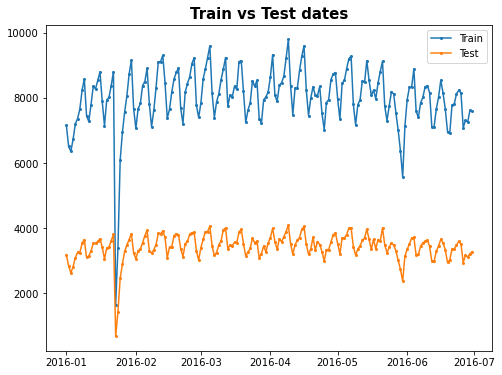

In [6]:
train['pickup_date'] = train['pickup_datetime'].dt.date
test['pickup_date'] = test['pickup_datetime'].dt.date

plt.figure(figsize = (8, 6))
plt.subplot(1, 1, 1)
plt.plot(train.groupby(['pickup_date'])['id'].count(), marker = 'o', markersize = 2, label = 'Train')
plt.plot(test.groupby(['pickup_date'])['id'].count(), marker = 'o', markersize = 2, label = 'Test')
plt.title('Train vs Test dates', fontsize = 15, fontweight = 'bold')
plt.legend()
plt.show()

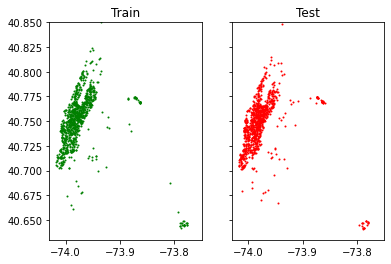

In [7]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:1000], train['pickup_latitude'].values[:1000],  color = 'green', s = 1)
ax[1].scatter(test['pickup_longitude'].values[:1000], test['pickup_latitude'].values[:1000], color = 'red', s = 1)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

### KMeans를 이용한 location data 클러스터링

In [8]:
# cluster pickup and dropoff locations: KMeans
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

kmeans = KMeans(n_clusters = 8, init = 'k-means++')
kmeans.fit(coords)

train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

### PCA로 location data 다르게 표현하기
PCA를 하는 이유는 location data의 variance를 최대한 반영하고, orthogonal한 변수들(components)을 생성하기 위함이다. 아래 그래프를 보면, 방향만 달라지고 location data의 shape은 잘 유지하는 것을 확인할 수 있다.

In [9]:
# PCA for location data
pca = PCA(n_components = 2).fit(coords)

train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

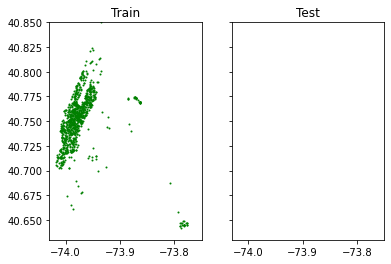

In [10]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:1000], train['pickup_latitude'].values[:1000],  color = 'green', s = 1)
ax[1].scatter(train['pickup_pca0'].values[:1000], train['pickup_pca1'].values[:1000], color = 'red', s = 1)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

### Feature Aggregation
Pickup, dropoff 클러스터, pickup 시간, 요일에 따라 trip duration과 average speed를 모델 feature로 구성하기 위해 aggregation을 진행한다.

In [11]:
# add aggregated features
agg_cols = ['pickup_cluster', 'dropoff_cluster', 'pickup_hour', 'pickup_weekday']

for col in agg_cols:
    gp = train.groupby(col).mean()[['log_trip_duration', 'avg_speed']]
    gp.columns = ['%s_gp_%s' % (col2, col) for col2 in gp.columns]
    train = pd.merge(train, gp, how = 'left', left_on = col, right_index = True)
    test = pd.merge(test, gp, how = 'left', left_on = col, right_index = True)

추가적으로, 전체 택스 루트 중 각 pickup과 dropoff 클러스터 조합에 해당하는 택시 사용량과 평균 속도를 feature로 추가한다.

In [12]:
cluster_comb = ['pickup_cluster', 'dropoff_cluster']
cluster_speed = train.groupby(cluster_comb).mean()[['avg_speed']].reset_index()
cluster_cnt = train.groupby(cluster_comb).count()[['id']].reset_index()
cluster_duration = train.groupby(cluster_comb).mean()[['log_trip_duration']].reset_index()
cluster = pd.merge(cluster_speed, cluster_cnt, on = cluster_comb)
cluster.columns = cluster_comb + ['avg_speed_%s' % '_'.join(cluster_comb), 'cnt_%s' %  '_'.join(cluster_comb)]

train = pd.merge(train, cluster, how='left', on = cluster_comb)
test = pd.merge(test, cluster, how='left', on = cluster_comb)

In [13]:
cluster.head(5)

,pickup_cluster,dropoff_cluster,avg_speed_pickup_cluster_dropoff_cluster,cnt_pickup_cluster_dropoff_cluster
0,0,0,0.004052,181119
1,0,1,0.005579,21678
2,0,3,0.010327,2194
3,0,4,0.005747,8262
4,0,5,0.003707,108307


In [14]:
train.drop(['id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
            'pickup_datetime', 'dropoff_datetime', 'pickup_date', 'dropoff_date',
            'log_trip_duration', 'avg_speed'], axis = 1, inplace = True)
test.drop(['id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_datetime', 'pickup_date'], axis = 1, inplace = True)

print(train.shape)
print(test.shape)

KeyError: "['dropoff_date'] not found in axis"

### Correlation heatmap
변수 간 correlation을 한 눈에 확인하기 위해 correlation heatmap을 그린다. 몇몇 변수들 간에 강한 상관관계가 보이기 때문에 일반선형회귀(Simple linear regression)은 적절하지 않다. 

--> 따라서 변수 간 상관관계를 고려하지 않아도 되는 Tree 계열의 regression 방법을 사용한다.

In [ ]:
plt.figure(figsize = (12, 10))
sns.heatmap(train.corr(), cmap = 'coolwarm', fmt = '.2f', annot = True, vmin = -1, vmax = 1)
plt.title('Correlation Heatmap', fontsize = 15, fontweight = 'bold')
plt.show()

In [ ]:
# categorical variables with object categories
train = pd.get_dummies(train)
test = pd.get_dummies(test)